In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import html
from sklearn.preprocessing import LabelEncoder
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch

pd.set_option('display.max_colwidth', 200)

### 1. Loading the Dataset

Loading the dataset using the simple pandas.read_csv



In [5]:
df = pd.read_csv('/content/twitter_sentiment_data.csv')

## 2. Exploratory Data Analysis

EDA helps understand the data's structure, patterns, and quality before modeling. It identifies issues like missing values and reveals insights for better decision-making.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43943 entries, 0 to 43942
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  43943 non-null  int64 
 1   message    43943 non-null  object
 2   tweetid    43943 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.0+ MB


In [7]:
df.describe()

,sentiment,tweetid
count,43943.000000,4.394300e+04
mean,0.853924,8.367966e+17
std,0.853543,8.568506e+16
min,-1.000000,5.926334e+17
25%,0.000000,7.970376e+17
50%,1.000000,8.402301e+17
75%,1.000000,9.020003e+17
max,2.000000,9.667024e+17


Checking the unique values in the 'sentiment' column

*   2 (News): factual news
*   1 (Pro): supports man-made climate change
*   0 (Neutral): neither supports nor refutes
*   -1 (Anti): does not believe in man-made climate change

In [8]:
df['sentiment'].unique()

array([-1,  1,  2,  0])

Checking for any duplicate elements

In [9]:
df.duplicated().sum()

np.int64(0)

Checking the distribution of the sentiment classes

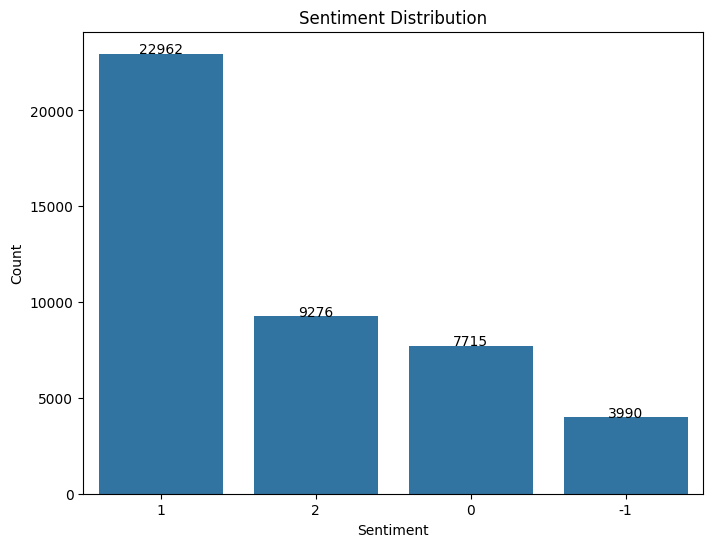

In [10]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='sentiment', order=df['sentiment'].value_counts().index)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.5, int(height), ha="center")

plt.show()

## Data preprocessing
Data preprocessing is a crucial step for NLP tasks. In this step, I clean the tweet text by removing URLs, mentions, hashtags, and any non-alphabetic characters. I also convert all text to lowercase and strip any extra spaces. This ensures that the text is ready for tokenization and model input.

In [11]:
df['message'].head(5)

,message
0,@tiniebeany climate change is an interesting hustle as it was global warming but the planet stopped warming for 15 yes while the suv boom
1,"RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change https://t.co/LkDehj3tNn httÃ¢â‚¬Â¦"
2,Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. https://t.co/7rV6BrmxjW via @youtube
3,RT @Mick_Fanning: Just watched this amazing documentary by leonardodicaprio on climate change. We all think thisÃ¢â‚¬Â¦ https://t.co/kNSTE8K8im
4,"RT @cnalive: Pranita Biswasi, a Lutheran from Odisha, gives testimony on effects of climate change &amp; natural disasters on the poÃ¢â‚¬Â¦"


In [12]:
def clean_text(text):
    text = text.lower()  # Lowercase
    text = html.unescape(text)  # Decode HTML entities like &amp;
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'rt\s+', '', text)  # Remove 'RT'
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters, numbers, emojis
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

In [13]:
df['clean_tweet'] = df['message'].apply(clean_text)

In [14]:
df['clean_tweet'].head()

,clean_tweet
0,climate change is an interesting hustle as it was global warming but the planet stopped warming for yes while the suv boom
1,watch right here as travels the world to tackle climate change htt
2,fabulous leonardo s film on change is brilliant do watch via
3,just watched this amazing documentary by leonardodicaprio on climate change we all think this
4,pranita biswasi a lutheran from odisha gives testimony on effects of climate change natural disasters on the po


### Encoding the Labels
Since machine learning models require numerical inputs, I encode the sentiment labels using LabelEncoder. This transforms the four sentiment labels into numeric values (0, 1, 2, 3) so they can be used as target labels for training the model.

In [15]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['sentiment'])  # -1 to 2 mapped to 0 to 3

### Train-Test Split
To evaluate the model’s performance effectively, I split the dataset into training and testing sets using an 80/20 split. The training set is used to train the model, and the test set is used to evaluate the model’s ability to generalize to unseen data. I ensure the split maintains the class distribution by using stratify.

In [16]:
from sklearn.model_selection import train_test_split

X = df['clean_tweet']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


### Baseline Model - TF-IDF + Logistic Regression
As a baseline model, I use a combination of TF-IDF (Term Frequency-Inverse Document Frequency) and Logistic Regression. First, I vectorize the tweet text using TfidfVectorizer, which transforms the text into numerical feature vectors. Then, I train a Logistic Regression model on the transformed features and evaluate its performance on the test set. I calculate metrics such as accuracy, F1-score, and present a confusion matrix to assess its classification performance.

Accuracy: 0.688474229150074
F1 Score (Weighted): 0.6715470583136712


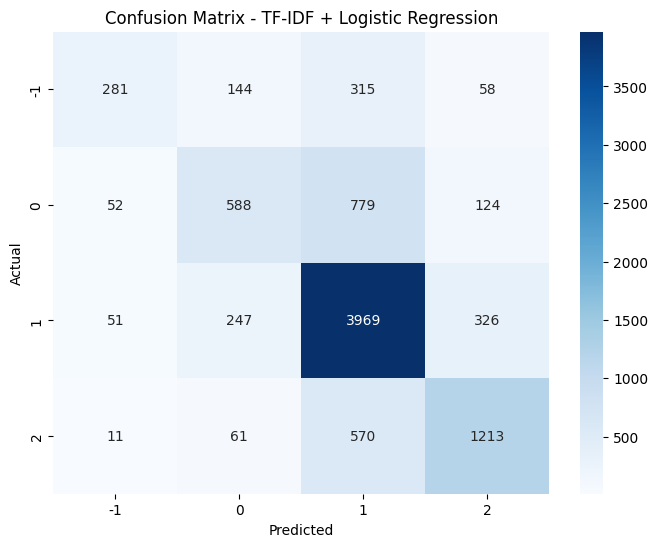

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Encode sentiment labels (if not already done)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['encoded_sentiment'] = le.fit_transform(df['sentiment'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_tweet'],
    df['encoded_sentiment'],
    test_size=0.2,
    random_state=42,
    stratify=df['encoded_sentiment']
)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

# Predict
y_pred = lr_model.predict(X_test_tfidf)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted' accounts for class imbalance

print("Accuracy:", accuracy)
print("F1 Score (Weighted):", f1)
#print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Optional: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - TF-IDF + Logistic Regression")
plt.show()

### Fine-tune Transformer Model (DistilBERT)
Next, I fine-tune a pre-trained DistilBERT model, which is a lighter and faster version of BERT (Bidirectional Encoder Representations from Transformers). DistilBERT is capable of handling complex language patterns and context, making it a great choice for sentiment analysis tasks. I tokenize the tweet text using the DistilBertTokenizerFast, and then fine-tune the model using the Trainer API from Hugging Face's transformers library. The model is trained to predict sentiment classes based on the input tweet text.

In [18]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Wrap our train/test data into Hugging Face Datasets format
train_ds = Dataset.from_pandas(pd.DataFrame({'text': X_train, 'label': y_train}))
test_ds = Dataset.from_pandas(pd.DataFrame({'text': X_test, 'label': y_test}))

# Tokenize: Convert text to input IDs and attention masks
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

train_ds = train_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

# Format the datasets for PyTorch
train_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/35154 [00:00<?, ? examples/s]

Map:   0%|          | 0/8789 [00:00<?, ? examples/s]

In [19]:
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=4
)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
from sklearn.metrics import accuracy_score, f1_score
from transformers import DataCollatorWithPadding
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1_macro': f1_score(labels, preds, average='macro')
    }

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    metric_for_best_model='accuracy'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)


In [21]:
trainer.train()
trainer.evaluate()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pranithachilvari1234 (pranithachilvari1234-university-of-arizona) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.838500
1000,0.683900
1500,0.517100
2000,0.463000
2500,0.347200
3000,0.266100


{'eval_loss': 0.7461682558059692,
 'eval_accuracy': 0.7659574468085106,
 'eval_f1_macro': 0.7145001166627605,
 'eval_runtime': 9.1891,
 'eval_samples_per_second': 956.457,
 'eval_steps_per_second': 15.018,
 'epoch': 3.0}

### Model Evaluation Summary
To evaluate the effectiveness of different modeling approaches for multiclass sentiment classification on the Climate Change Tweet Dataset, I compared a traditional machine learning model (TF-IDF + Logistic Regression) with a fine-tuned transformer-based model (DistilBERT).

#### Baseline Model: TF-IDF + Logistic Regression
Accuracy: 0.6887

F1 Score (Weighted): 0.6715

The baseline model provides a decent performance using simple text vectorization and a linear classifier. However, it struggles to fully capture contextual nuances in the tweets, especially for more subjective sentiment classes like Pro and Anti.

#### Transformer Model: DistilBERT (Fine-tuned)
Eval Accuracy: 0.7659

Eval F1 Score (Macro): 0.7145

Eval Loss: 0.7461

Epochs: 3

The DistilBERT model significantly outperforms the baseline, achieving over 76% accuracy and a macro F1 score of ~0.71, indicating better balanced performance across all sentiment classes. As a contextual language model, DistilBERT is better able to understand subtle patterns in language and provides a more robust solution to the multiclass sentiment classification task.